# Import


In [6]:
!pip install  yfinance tensorflow_probability seaborn matplotlib sklearn google.colab
import yfinance as yf

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import sts

import matplotlib.dates as mdates
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from google.colab import files
import csv

import os

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")
%config InlineBackend.figure_format = 'retina'

os.path.expanduser('~')
sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)
plt.rcParams['image.cmap'] = 'viridis'

%matplotlib inline
tfd = tfp.distributions

     |████████████████████████████████| 72 kB 1.2 MB/s eta 0:00:011
     |████████████████████████████████| 64 kB 3.3 MB/s eta 0:00:011
     |████████████████████████████████| 104 kB 9.6 MB/s eta 0:00:01
     |████████████████████████████████| 758 kB 10.0 MB/s eta 0:00:01
     |████████████████████████████████| 8.0 MB 6.6 MB/s eta 0:00:01
     |████████████████████████████████| 484 kB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 245 kB 7.9 MB/s eta 0:00:01


  Created wheel for google.colab: filename=google_colab-1.0.0-py2.py3-none-any.whl size=102275 sha256=9d1aae27bec1fe9ddc7d9deb405cc5d0cfb6f8db213176af0a56229593ce1b3d
  Stored in directory: /home/janik/.cache/pip/wheels/e4/e7/91/b2736701bca00e273fdc79f80e2727b558e0903d81b758eb69
  Created wheel for portpicker: filename=portpicker-1.2.0-py3-none-any.whl size=13369 sha256=368f688207eb32bb5a83140f0c732308dfc8c501a378306e037fef6d3d01b39f
  Stored in directory: /home/janik/.cache/pip/wheels/b9/10/77/cad2fb4f8ab57cc7cecb92b9b1b0548ac932b8f81774003683
  Created wheel for tornado: filename=tornado-4.5.3-cp38-cp38-linux_x86_64.whl size=433339 sha256=c1cb30feb971803c93142d7d9bd251e0b9c995cbe2f486de28b4bf9800ea81d9
  Stored in directory: /home/janik/.cache/pip/wheels/20/fe/26/0c03adccd0cec2744261ec6b8380fbe5e726d1ea4cf3a9370e
  Created wheel for simplegeneric: filename=simplegeneric-0.8.1-py3-none-any.whl size=5074 sha256=d7985aabf19541f9b01e7947841eda16fb523fa9820098094335d688b25d5704
  Stored i

    Uninstalling notebook-6.4.11:
      Successfully uninstalled notebook-6.4.11


/home/janik/Documents/KIT/Master/Seminar NSDDP/source/.venv/lib/python3.8/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


#Data Download Utils

In [7]:
def download_daily_price(ticker_list, start='2015-01-01', end='2020-01-01'):
  ticket_str = ' '.join(ticker_list)
  data = yf.download(  # or pdr.get_data_yahoo(...
    # tickers list or string as well
    tickers = ticket_str,

    # use "period" instead of start/end
    # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
    # (optional, default is '1mo')
    # period = time_period,
    start = start,
    end = end,

    # fetch data by interval (including intraday if period < 60 days)
    # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
    # (optional, default is '1d')
    interval = "1d",

    # group by ticker (to access via data['SPY'])
    # (optional, default is 'column')
    group_by = 'ticker',

    # adjust all OHLC automatically
    # (optional, default is False)
    auto_adjust = True,

    # download pre/post regular market hours data
    # (optional, default is False)
    # prepost = True,

    # use threads for mass downloading? (True/False/Integer)
    # (optional, default is True)
    threads = True,

    # proxy URL scheme use use when downloading?
    # (optional, default is None)
    proxy = None
  )
  return data

def get_open_price_dict(ticker_list, start_date='2015-01-01'):
  # Returns a dict {ticker: zip([timestamps], [Open_prices])}
  data = download_daily_price(ticker_list=ticker_list, start=start_date)
  open_price_dict = {
      ticker: data[ticker]['Open'].values.tolist() for ticker in ticker_list}
  return open_price_dict, data.index.tolist()

def get_nasdaq_stock_price(num_stocks=1000):
  # upload nasdaq listed stock CSV, which is downloaded from here
  # https://www.nasdaq.com/market-activity/stocks/screener
  uploaded_nasdaq_csv = files.upload()
  for v in uploaded_nasdaq_csv.values():
    stock_list = v.decode().split('\r\n')
  ticker_list = [stock.split(',')[0] for stock in stock_list]
  # Get the first num_stocks stocks from the list for study.
  open_price_dict, date_range = get_open_price_dict(ticker_list[1:num_stocks], start_date='2019-01-01')
  return open_price_dict, date_range

In [8]:
def clean_stock_price_list(open_price_dict):
  # Remove stocks with nan as price using AAPL as a baseline.
  # AAPL also has a few nan prices depending on the date range.
  # We remove these dates from the study.
  nan_index = []
  for i, x in enumerate(open_price_dict['AAPL']):
    if math.isnan(float(x)):
      nan_index.append(i)
  print(nan_index)

  cleaned_price_list = []
  skip_ticker_list = []
  for ticker, price_list in open_price_dict.items():
    skip = False
    for i, x in enumerate(open_price_dict[ticker]):
      if i not in nan_index and math.isnan(float(x)):
        # A ticker with more nan than AAPL. skip
        skip_ticker_list.append(ticker)
        skip = True
        break
    if not skip:      
      cleaned_price_list.append(np.delete(np.array(price_list), nan_index))
  print('number of all stocks : ' + str(len(open_price_dict)))
  print('number of cleaned stocks: ' + str(len(cleaned_price_list)))
  print('number of skipped stocks: ' + str(len(skip_ticker_list)))
  return cleaned_price_list, skip_ticker_list, nan_index    

# Visualization Utils


In [9]:
def plot_coefficient_heatmap(correlation_matrix, ticker_list):
  # correlation_matrix is a ndarray with shape (n, 2*n), n being the number of tickers.
  print(correlation_matrix.shape)
  num_ticker = correlation_matrix.shape[0]
  order = correlation_matrix.shape[1]//num_ticker
  fig, axes = plt.subplots(nrows=1, ncols=order, figsize=(3*order, 3))

  for i in range(order):
    df = pd.DataFrame(correlation_matrix[:, i*num_ticker:(i+1)*num_ticker], columns=ticker_list, index=ticker_list)
    #df_order1 = pd.DataFrame(correlation_matrix[:, num_ticker:], columns=ticker_list, index=ticker_list)
    sns.heatmap(df, ax=axes[i], cbar=True)
    #sns.heatmap(df_order1, ax=axes[1], cbar=True)
  fig.tight_layout()
  plt.show()

def plot_hist(list_prices, n_bins=20):
  fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
  x = open_price_dict['GOOG']
  y = open_price_dict['AAPL']
  # We can set the number of bins with the `bins` kwarg
  axs[0].hist(x, bins=n_bins)
  axs[1].hist(y, bins=n_bins)

def format_and_print_list(input_list):
  print(', '.join('{:.3f}'.format(element) for element in input_list)) 

def format_and_print_2d_params(input_array, reverse_order):
  output_str_list = []
  for ticker_list in input_array:
    if reverse_order:
      for element in reversed(ticker_list):
        output_str_list.append(element)
    else:
      for element in ticker_list:
        output_str_list.append(element)

  print(', '.join('{:.3f}'.format(element) for element in output_str_list))

def plot_ticker_ts(date_range, open_price_dict, ticker, forecast_horizon):
  prices = open_price_dict[ticker][:-forecast_horizon]

  plot_x_loc = mdates.AutoDateLocator()  # every two months.
  plot_x_fmt = mdates.DateFormatter('%Y/%m/%d')


  fig = plt.figure(figsize=(12, 6))
  ax = fig.add_subplot(1, 1, 1)
  ax.plot(date_range, prices, lw=2, label="training data")
  ax.xaxis.set_major_locator(plot_x_loc)
  ax.xaxis.set_major_formatter(plot_x_fmt)
  ax.set_ylabel("price")
  ax.set_xlabel("day")
  fig.suptitle(ticker + " price", fontsize=15)
  ax.text(0.99, .02, "Source: Yahoo finance", transform=ax.transAxes, horizontalalignment="right", alpha=0.5)
  fig.autofmt_xdate()



In [10]:
def plot_forecast(x, y, forecast_horizon,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, ax, x_locator=None, x_formatter=None):
  """Plot a forecast distribution against the 'true' time series."""
  colors = sns.color_palette()
  c1, c2 = colors[0], colors[1]
  fig = plt.figure(figsize=(12, 6))

  ax.plot(x, y, lw=2, color=c1, label='ground truth')
  ax.plot(forecast_horizon, forecast_samples.T, lw=1, color=c2, alpha=0.1)
  ax.plot(forecast_horizon, forecast_mean, lw=2, ls='--', color=c2, label='forecast')
  ax.fill_between(forecast_horizon,
                  forecast_mean-2*forecast_scale,
                  forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

  ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
  yrange = ymax-ymin
  ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
  ax.set_title("{}".format(title))
  ax.legend()

  if x_locator is not None:
    ax.xaxis.set_major_locator(x_locator)
    ax.xaxis.set_major_formatter(x_formatter)
    fig.autofmt_xdate()

  return fig, ax

# Models

In [11]:
def build_model(observed_time_series, ar_order):
  #day_of_week_effect = sts.Seasonal(
  #    num_seasons=7,
  #    observed_time_series=observed_time_series,
  #    name='day_of_week_effect')
  # trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)  
  autoregressive = sts.Autoregressive(
      order=ar_order,
      observed_time_series=observed_time_series,
      name='autoregressive')
  #model = sts.Sum([day_of_week_effect,
  #                 autoregressive],
  #                 observed_time_series=observed_time_series)
  model = sts.Sum([autoregressive],
                   observed_time_series=observed_time_series)  
  return model

def train_model(training_price_ts, stock_model, num_train_steps):
  # Build the variational surrogate posteriors `qs`.
  variational_posteriors = tfp.sts.build_factored_surrogate_posterior(
      model=stock_model)
  optimizer = tf.optimizers.Adam(learning_rate=.1)
  # Using fit_surrogate_posterior to build and optimize the variational loss function.
  @tf.function(experimental_compile=True)
  def train():
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
      target_log_prob_fn=stock_model.joint_log_prob(
          observed_time_series=training_price_ts),
      surrogate_posterior=variational_posteriors,
      optimizer=optimizer,
      num_steps=num_train_steps)
    return elbo_loss_curve
  elbo_loss_curve = train()
  plt.plot(elbo_loss_curve)
  plt.show()
  return variational_posteriors  

def train_for_stocks(open_price_dict, ticker_list, ar_order):
  ts_list = []
  for ticker in ticker_list:
    ts_list.append(np.array(open_price_dict[ticker]))
  training_price_ts = np.stack(ts_list, axis=0)

  stock_model = build_model(training_price_ts, ar_order=ar_order)
  variational_posteriors = train_model(training_price_ts, stock_model, num_train_steps=250)
  return training_price_ts, stock_model, variational_posteriors  

def train_for_clusters(cleaned_price_list, n_clusters=8, ar_order=5):
  X = np.array(cleaned_price_list)  # X.shape (num_stock, num_days)
  print(X.shape) # (588, 252)
  clustering = KMeans(n_clusters=n_clusters)
  clustering.fit(X)
  cluster_mean_list = clustering.cluster_centers_
  print(cluster_mean_list.shape) # (8, 252)

  stock_model = build_model(cluster_mean_list, ar_order=ar_order)
  variational_posteriors = train_model(cluster_mean_list, stock_model, num_train_steps=250)
  return cluster_mean_list, stock_model, variational_posteriors    

# Import Data and Train Model


## Train on stocks

[*********************100%***********************]  5 of 5 completed


2022-04-26 22:24:45.219362: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-26 22:24:45.219701: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-26 22:24:45.219806: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-04-26 22:24:45.219893: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-04-26 22:24:45.219980: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Instructions for updating:
Do not call `graph_parents`.


2022-04-26 22:24:50.439583: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x8866550 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-26 22:24:50.439758: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2022-04-26 22:24:50.570100: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. fit_surrogate_posterior/StatefulPartitionedCall/monte_carlo_variational_loss/default_joint_bijectorJointDistributionNamedAutoBatched_CONSTRUCTED_AT_monte_carlo_variational_loss_build_factored_surrogate_posterior_1/sample_and_log_prob/JointDistributionNamedAutoBatched/sample_and_log_prob/sanitize_seed/seed
2022-04-26 22:24:50.582934: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:237] disabling MLIR crash reproducer, set

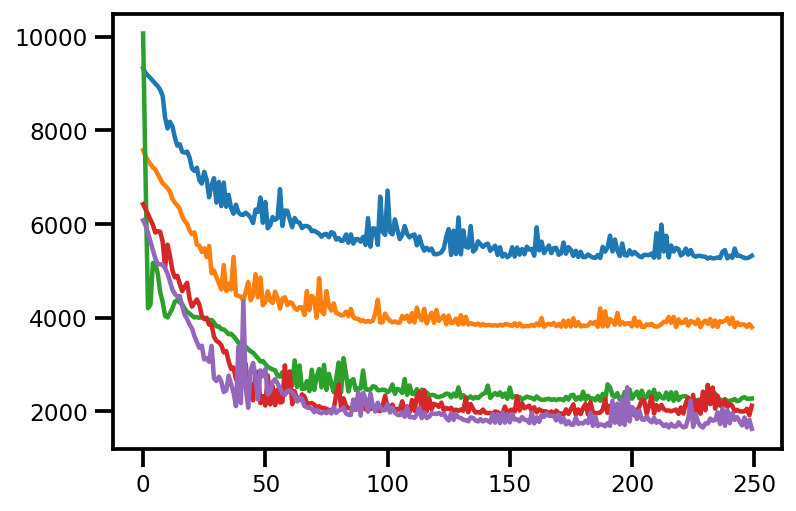

In [12]:
short_ticker_list = ['GOOG', 'COKE', 'LOW', 'JPM', 'BBBY']
#tech_ticker_list = ['GOOG', 'AAPL', 'MSFT', 'AMZN', 'FB', 'IBM', 'NVDA', 'INTC', 'NFLX', 'TWTR']

open_price_dict, date_list = get_open_price_dict(short_ticker_list)

training_price_ts, stock_model, variational_posteriors = train_for_stocks(open_price_dict, short_ticker_list, ar_order=5)

## Train on stock clusters

In [ ]:
open_price_dict, date_list = get_nasdaq_stock_price(num_stocks=1000)
cleaned_price_list, skip_ticker_list, nan_index = clean_stock_price_list(open_price_dict)


In [ ]:
training_price_ts, stock_model, variational_posteriors = train_for_clusters(cleaned_price_list, n_clusters=8, ar_order=5)

# Inference and Plot

In [14]:
FORECAST_HORIZON = 5

# Draw samples from the variational posterior.
def get_inferred_params(stock_model, variational_posteriors):
  q_samples_ = variational_posteriors.sample(20)
  param_dict = {}
  print("Inferred parameters:")
  for param in stock_model.parameters:
    sample_mean = np.mean(q_samples_[param.name], axis=0)
    sample_std = np.std(q_samples_[param.name], axis=0)
    print("{}: {} +- {}".format(param.name, sample_mean, sample_std))
    param_dict[param.name] = (sample_mean, sample_std)
  return param_dict, q_samples_ 

def get_forecast(stock_model, hist_ts, q_samples_, num_sample_traj):
  forecast_dist = tfp.sts.forecast(
    model=stock_model,
    observed_time_series=hist_ts,  # training_price_ts[:, :10],
    parameter_samples=q_samples_,
    num_steps_forecast=FORECAST_HORIZON)
  # print(forecast_dist.mean().numpy().shape) (num_ticker, forecast_horizon, 1)
  (forecast_mean, forecast_scale, forecast_samples) = (
      forecast_dist.mean().numpy()[:, :, 0],
      forecast_dist.stddev().numpy()[:, :, 0],
      forecast_dist.sample(num_sample_traj).numpy()[:, :, :, 0])
  return (forecast_mean, forecast_scale, forecast_samples)  

## Get Inferred Params


In [15]:
param_dict, q_samples_ = get_inferred_params(stock_model, variational_posteriors)

Inferred parameters:
observation_noise_scale: [3.0533455  0.34015776 0.5423035  0.23771796 0.09823244] +- [0.41795157 0.14519434 0.02950448 0.01777986 0.02854703]
autoregressive/_coefficients: [[ 0.67901486  0.56871608 -0.2138743  -0.15918824  0.14278847]
 [ 0.83732625  0.24784953 -0.04854554 -0.0371374   0.01615313]
 [ 0.81701383  0.41054774  0.10149295 -0.59502469  0.28449461]
 [ 0.98142904  0.25574617 -0.25490519 -0.19539987  0.19717094]
 [ 0.34334596  0.54100364  0.75566025 -0.76238755  0.13973831]] +- [[0.00150479 0.00339483 0.00150341 0.00337425 0.00323802]
 [0.00067602 0.00182444 0.0018797  0.00199057 0.00327076]
 [0.00133455 0.00144535 0.00436045 0.00424196 0.00136915]
 [0.00120365 0.0014147  0.00275154 0.00172151 0.00070585]
 [0.001144   0.00230163 0.00086877 0.00165845 0.00165821]]
autoregressive/_level_scale: [16.68619639  5.01236172  1.16593311  0.95446667  0.92111215] +- [0.35165413 0.0859073  0.032926   0.0166818  0.01358228]


In [16]:
format_and_print_2d_params(param_dict['autoregressive/_coefficients'][0], reverse_order=True)
format_and_print_list(param_dict['autoregressive/_level_scale'][0])


0.143, -0.159, -0.214, 0.569, 0.679, 0.016, -0.037, -0.049, 0.248, 0.837, 0.284, -0.595, 0.101, 0.411, 0.817, 0.197, -0.195, -0.255, 0.256, 0.981, 0.140, -0.762, 0.756, 0.541, 0.343
16.686, 5.012, 1.166, 0.954, 0.921


## Plot Forecast

In [17]:
def plot_all_forecast(series_list, stock_model, training_price_ts, date_list):
  forecast_mean, forecast_scale, forecast_samples = get_forecast(stock_model, training_price_ts[:, plot_start_date_index:forecast_start_date_index], q_samples_, num_sample_traj)
  # series_list is a list of ticker names or clusters id_strs.
  num_series = len(series_list)
  fig, axes = plt.subplots(nrows=num_series, ncols=1, figsize=(20, 4*num_series))

  for i in range(num_series):
    fig, ax = plot_forecast(x=date_list[plot_start_date_index:plot_end_date_index], 
                            y=tf.squeeze(training_price_ts[i:i+1, plot_start_date_index:plot_end_date_index], axis=0),
                            forecast_horizon=date_list[forecast_start_date_index:plot_end_date_index],
                            forecast_mean=forecast_mean[i],
                            forecast_scale=forecast_scale[i],
                            forecast_samples=forecast_samples[:, i, :],
                            title="forecast " + series_list[i], ax=axes[i])
  fig.tight_layout()

In [18]:
forecast_start_date_index = 50
HISTORY_WINDOW = 5
plot_start_date_index =  forecast_start_date_index - HISTORY_WINDOW
plot_end_date_index = forecast_start_date_index + FORECAST_HORIZON
num_sample_traj = 9
format_and_print_2d_params(training_price_ts[:, plot_start_date_index:forecast_start_date_index], reverse_order=False)
print(date_list[plot_start_date_index:forecast_start_date_index])


565.308, 562.705, 553.620, 551.995, 551.984, 99.008, 100.835, 101.232, 101.242, 102.209, 64.897, 65.100, 64.580, 64.871, 66.142, 49.852, 49.787, 49.271, 49.697, 50.311, 63.909, 64.912, 64.703, 64.712, 65.104
[Timestamp('2015-03-09 00:00:00'), Timestamp('2015-03-10 00:00:00'), Timestamp('2015-03-11 00:00:00'), Timestamp('2015-03-12 00:00:00'), Timestamp('2015-03-13 00:00:00')]


InvalidArgumentError: Can not squeeze dim[0], expected a dimension of 1, got 0 [Op:Squeeze]

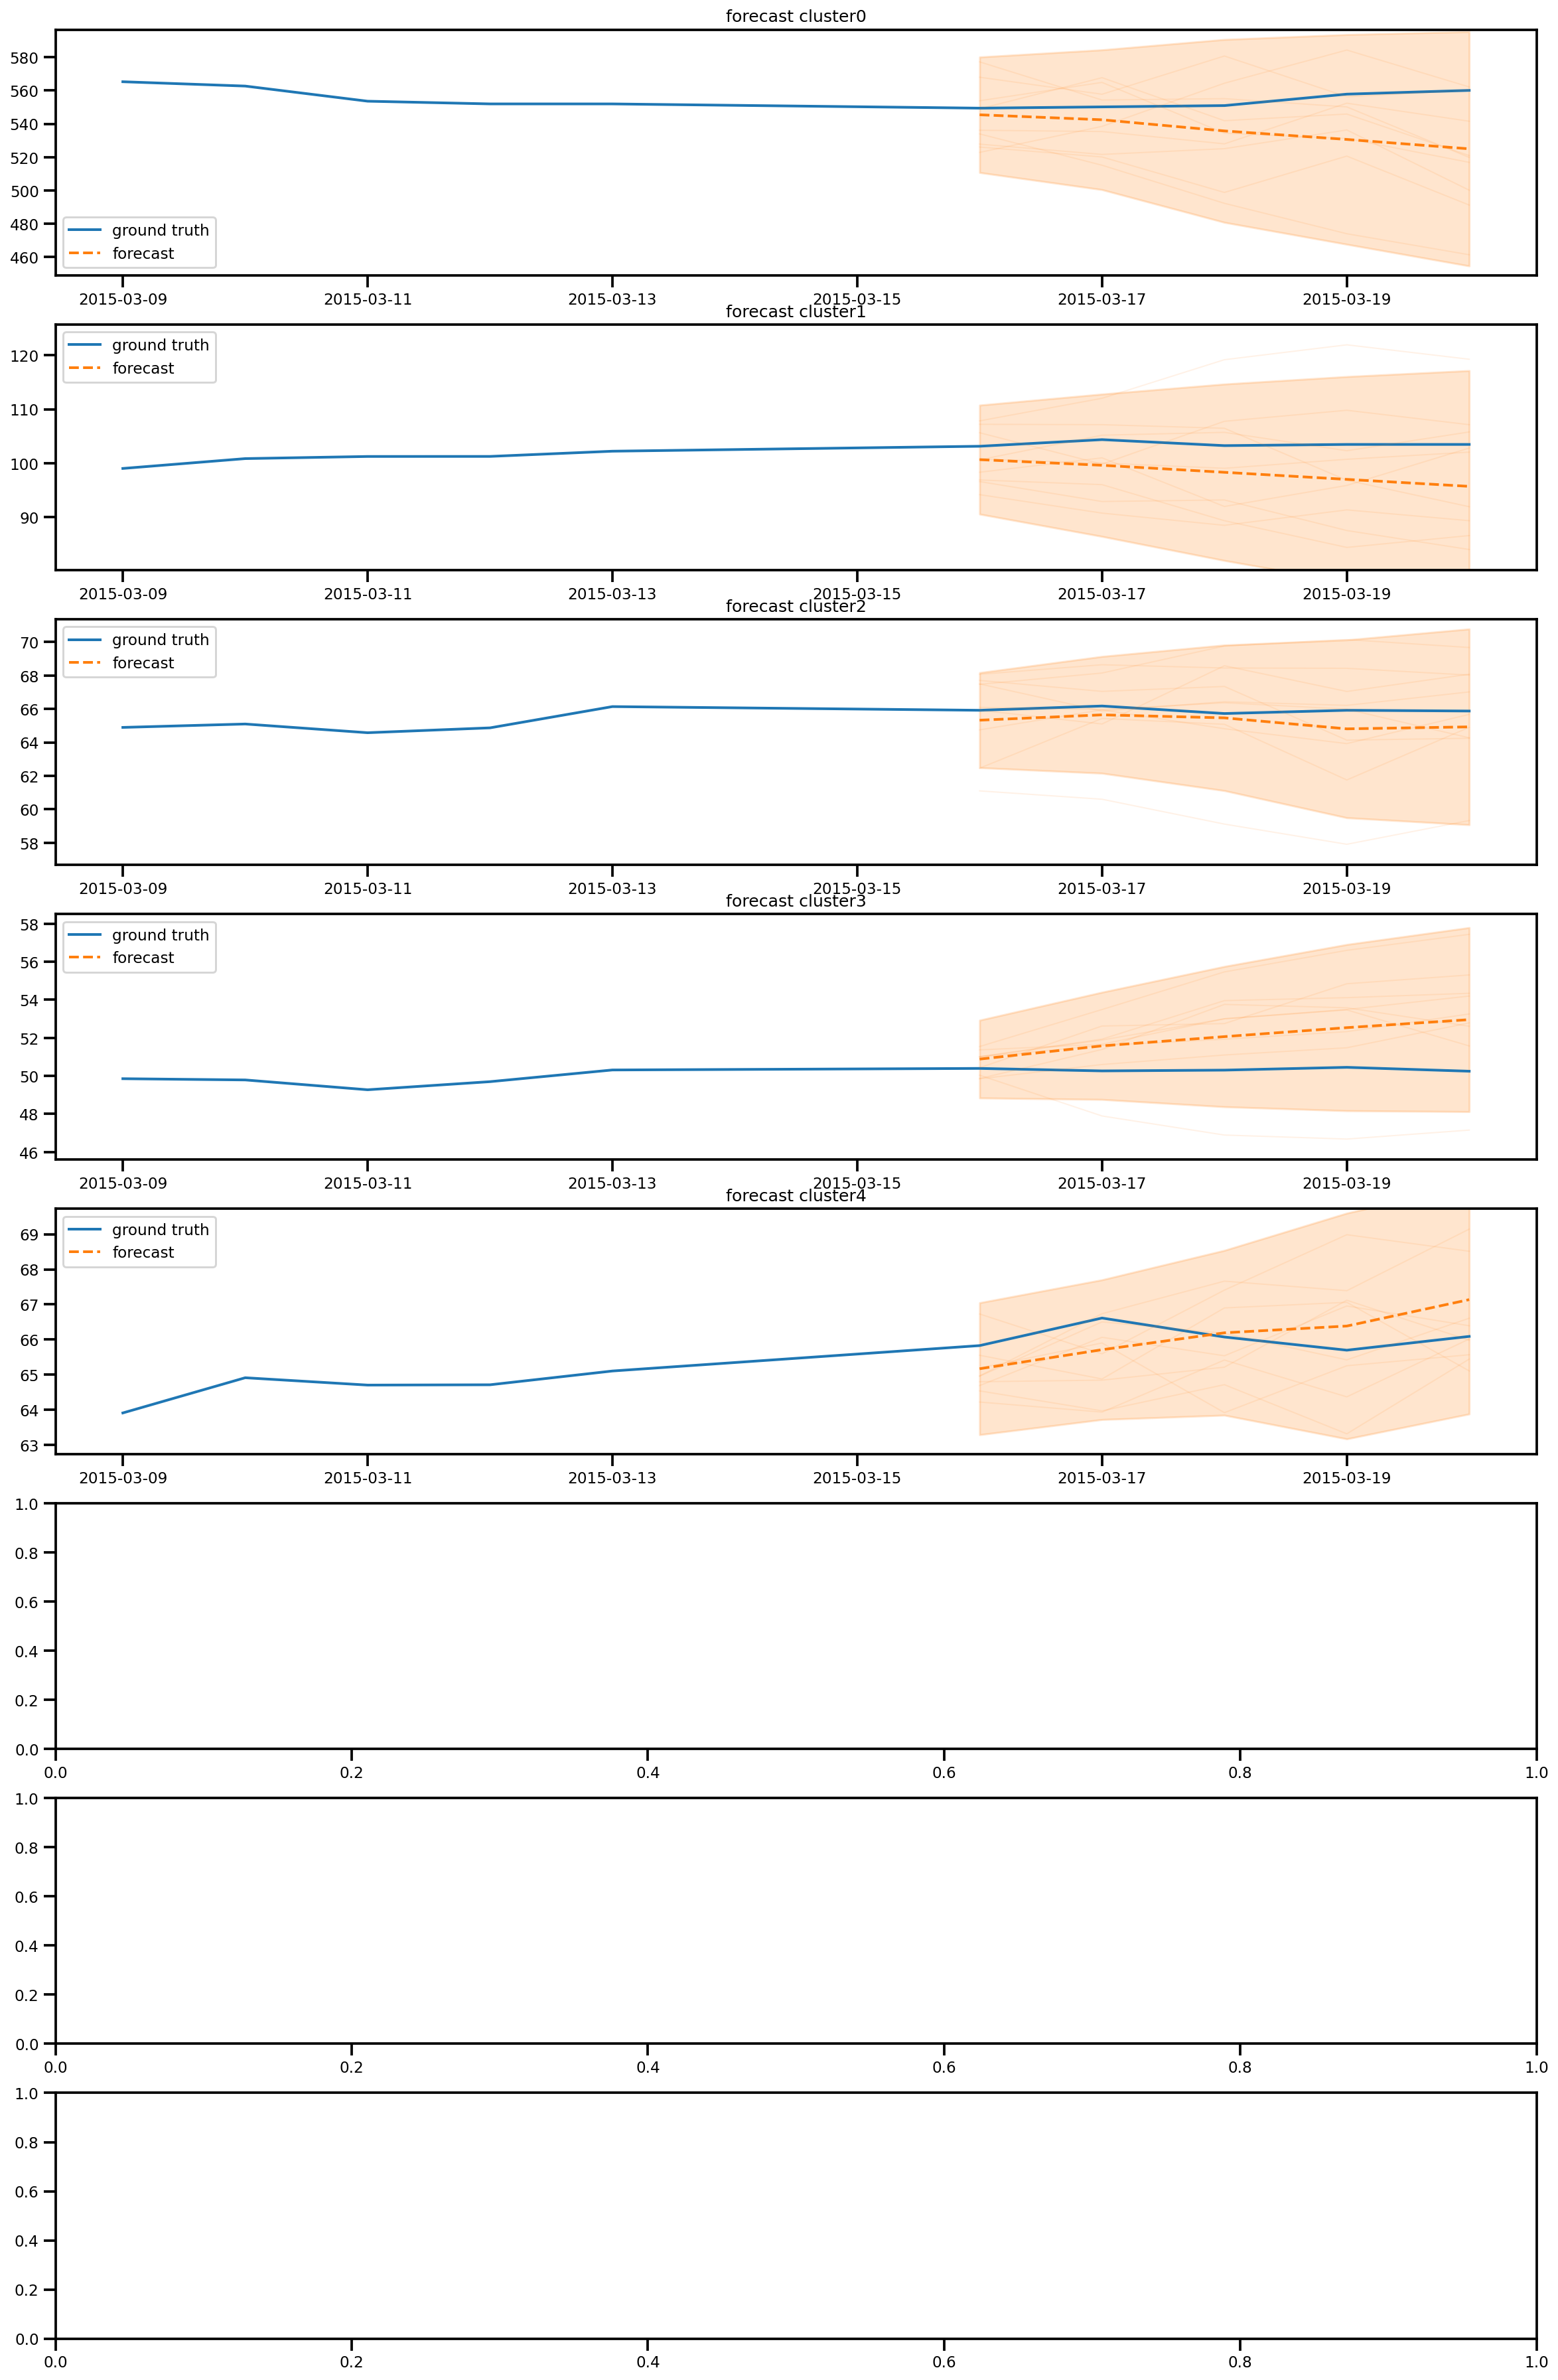

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

<Figure size 864x432 with 0 Axes>

In [19]:
plot_all_forecast(['cluster' + str(i) for i in range(8)], stock_model, training_price_ts, date_list)